# Exploratory Data Analysis  on Ml-10M100k

Notebook to perform data explorationi on Movie 10M 

1. Understand user and movie distributions

2. Preprocess ratings: normalize, filter users/movies with few interactions

3. Merge with metadata if need be (genres, titles, etc.)

From teh Readme, the Mk-10m file contains:

| File          | Description                             | Relevance to Project                           |
| ------------- | --------------------------------------- | ---------------------------------------------- |
| `ratings.dat` | User ratings for movies with timestamps | **Core reward signal**; your "bandit feedback" |
| `movies.dat`  | Movie titles and genres                 | **Contextual features** (genre) and metadata   |
| `tags.dat`    | User-generated tags on movies           | Optional: more **contextual info** for movies  |


In [1]:
import numpy as np
import pandas as pd

## EDA on Ratings

Find out
1. Total number of users, movies and rating
2. Rating distribution
3. Plot number of ratings per user, and per movie for popularity

Filter out
- Users with too few ratings (e.g., <10).
- Movies with very few ratings (e.g., <5).


### 1. Total number of users, movies and rating

In [2]:
rating_cols = ['UserID','MovieID','Rating','Timestamp']
ratings = pd.read_csv("../data/ml-10M100K/ratings.dat", sep="::",names = rating_cols)

/tmp/ipykernel_3012/1043898624.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("../data/ml-10M100K/ratings.dat", sep="::",names = rating_cols)


In [3]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [4]:
#Total number of users
total_users = ratings.UserID.unique()
print(f" the total number of unique users are {len(total_users)}")

 the total number of unique users are 69878


In [5]:
#Total number of movies
total_movies = ratings.MovieID.unique()
print(f"the total number of unique movies are {len(total_movies)}")

the total number of unique movies are 10677


In [6]:
#Total number of raitngs
total_ratings = ratings.Rating.unique()
total_ratings.sort()
print(f"the total number of unique Rating are {len(total_ratings)}\nand they are {total_ratings}")

the total number of unique Rating are 10
and they are [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


### 2. Rating destribution

Understanding how users rate items. This gives us intuition about the following:

- User behavior (Are users generous? Are they biased?)
- Sparsity or skewness in the data
- Potential bias in the reward function (in bandits or RL framing)
- What a baseline model (like random or popularity-based) might look like


In [7]:
#Mean Rating

average_rating = ratings['Rating'].mean()
print(f"Average user preference (mean rating): {average_rating:.2f}")

Average user preference (mean rating): 3.51


In [8]:
# Variance and Standard Deviation of Ratings
rating_variance = ratings["Rating"].var()
rating_std = ratings["Rating"].std()
print(f"Variance of ratings: {rating_variance:.2f}")
print(f"Standard deviation of ratings: {rating_std:.2f}")

Variance of ratings: 1.12
Standard deviation of ratings: 1.06


High variance → polarized opinions (some love it, some hate it).

Low variance → users agree more or are more neutral.

This is low var/std

In [9]:
#Mean and Variance Interpretation per movie
mean_ratings_per_movie = ratings.groupby('MovieID')['Rating'].mean()
variance_ratings_per_movie = ratings.groupby('MovieID')['Rating'].var()
rating_counts_per_movie = ratings.groupby('MovieID')['Rating'].count()


In [10]:
# mean
mean_ratings_per_movie

MovieID
1        3.928769
2        3.208070
3        3.150385
4        2.860544
5        3.077435
           ...   
65088    3.062500
65091    3.666667
65126    3.666667
65130    2.250000
65133    3.357143
Name: Rating, Length: 10677, dtype: float64

In [11]:
#var 
variance_ratings_per_movie

MovieID
1        0.803380
2        0.905024
3        1.010345
4        1.183037
5        0.931030
           ...   
65088    1.102679
65091    0.083333
65126    0.583333
65130    0.125000
65133    1.726190
Name: Rating, Length: 10677, dtype: float64

In [12]:
#count
rating_counts_per_movie

MovieID
1        26449
2        12032
3         7790
4         1764
5         7135
         ...  
65088        8
65091        3
65126        3
65130        2
65133        7
Name: Rating, Length: 10677, dtype: int64

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

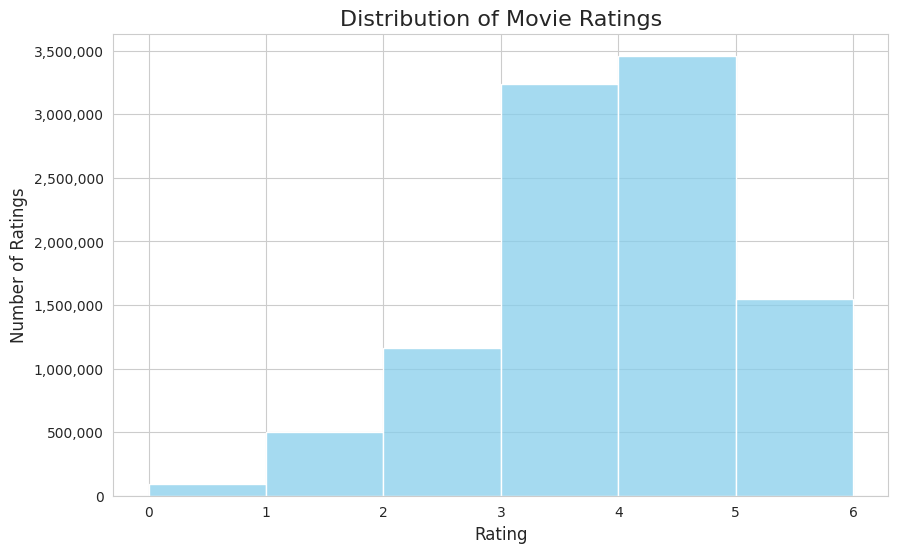

In [14]:
# Histogram for Rating Desitribution 

# Set the style of the visualization for a clean look
sns.set_style("whitegrid")

# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

sns.histplot(data=ratings, x='Rating', bins=9, kde=False, color='skyblue', discrete=True)

plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()


📊 Observations from the Histogram
Skewed Toward High Ratings:

The majority of ratings are 3.0, 4.0, and 5.0.

4.0 has the highest number of ratings, followed by 3.0 and 5.0.

Low ratings (0.5–2.0) are relatively rare.

Imbalanced Rating Distribution:

This is typical of real-world datasets where:

Users are more likely to rate movies they liked.

There’s a positivity bias—many people avoid giving bad ratings unless a movie is extremely poor.

This will affect learning, especially in reinforcement learning (RL) or bandit setups, where positive feedback dominates.

Implication on Multi-Armed Bandit Setting:

If you model each movie as an arm, the average reward (mean rating) per movie will generally be biased upwards.

Variance will help identify how confidently you can expect a particular movie’s rating.

## EDA on movies dataset

In [15]:
movies_cols = ['MovieID','Title','Genres']
movies = pd.read_csv("../data/ml-10M100K/movies.dat", sep="::",names = movies_cols)

/tmp/ipykernel_3012/1942783614.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("../data/ml-10M100K/movies.dat", sep="::",names = movies_cols)


In [ ]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
# Extract the year from the Title column
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)').astype(float)

# Extract the movie title without the year
movies['Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.strip()

In [18]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [19]:
#Create Multi-Hot Genre Encoding 
#These features can be used in contextual representations of items (arms), useful for LinUCB or Neural Bandits.


all_genres = sorted(set('|'.join(movies['Genres']).split('|')))
genre_map = {genre: idx for idx, genre in enumerate(all_genres)}


In [20]:
import numpy as np

def multi_hot_encode(genres_str, genre_map):
    vec = np.zeros(len(genre_map), dtype=int)
    for genre in genres_str.split('|'):
        vec[genre_map[genre]] = 1
    return vec

# Apply to each row
genre_features = movies['Genres'].apply(lambda g: multi_hot_encode(g, genre_map))
genre_df = pd.DataFrame(genre_features.tolist(), columns=[f"Genre_{g}" for g in all_genres])


In [21]:
# Combine with the main movies DataFrame
movies = pd.concat([movies, genre_df], axis=1)

In [ ]:
# Combine with the main movies DataFrame with the ratings DataFrame, making sure all the movies and ratings are alines


In [22]:
movies.head()

,MovieID,Title,Genres,Year,Genre_(no genres listed),Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children,Genre_Comedy,...,Genre_Film-Noir,Genre_Horror,Genre_IMAX,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
genre_df.shape

(10681, 20)

In [25]:
movies.shape

(10681, 24)

In [26]:
#save to a new csv file called preprocessed_movies.csv
movies.to_csv("../data/ml-10M100K/preprocessed_movies.csv", index=False)
print("Preprocessed movies saved to ../data/ml-10M100K/preprocessed_movies.csv")

Preprocessed movies saved to ../data/ml-10M100K/preprocessed_movies.csv
